## Code 3: Using simultaneous magnetosheath measurements to estimate magnitude uncertainty of driver
By Nithin Sivadas 

Using Bayane Michotte de Welle dataset

Last updated: 25 Sep 2025

In this code, we use a database of measurements from Cluster, Double Star, THEMIS, and MMS Missions, classified into magnetosheath and solar wind (upstream of bowshock) plasma region, in order to estimate the uncertainty (or variance) in the kan-lee electric field estimated using solar wind measurements at L1 from the OMNI database relative to magnetosheath measurements made close to the subsolar point. 

In [63]:
# Initializing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants as cst
from datetime import timedelta, datetime, timezone
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from scipy.ndimage import gaussian_filter as gf


from scipy import stats

from spok.models import planetary as smp
from spok import smath as sm
from spok.coordinates import coordinates as scc
from spok import utils as su

from scipy.interpolate import griddata

from sklearn.neighbors import KNeighborsRegressor

#import speasy as spz
#from speasy.products import SpeasyVariable
from typing import List

import spacepy.omni as spo

from matplotlib.colors import LogNorm

%matplotlib widget

msh = smp.Magnetosheath(magnetopause='mp_shue1998', bow_shock ='bs_jelinek2012')

For the methodology of creation of this database see chapter 2 : https://theses.hal.science/tel-04661957v1/document 
Michotte de Welle et al., 2024 : https://doi.org/10.3389/fspas.2024.1427791427791/full

#### Reading Data from Pickle files

In [64]:
# Reading Data from the Pickle files

# Data from spacecraft within magnetosheath (ms)
data_ms = pd.read_pickle('./Datasets/data_gsm_v2.pkl') 
pos_ms = pd.read_pickle('./Datasets/pos_gsm_v2.pkl') 
omni_ms = pd.read_pickle('./Datasets/omni_gsm_v2.pkl') # OMNI1 time-shifted to match with the magnetosheath data by Bayane
r_norm_ms = pd.read_pickle('./Datasets/r_norm_v2.pkl')

# Data from spacecraft just upstream of the bow shock (bs)
data_bs = pd.read_pickle('./Datasets/all_sat_SW_data.pkl')
pos_bs = pd.read_pickle('./Datasets/all_sat_SW_pos.pkl')

In [65]:
# Load omni data corresponding to the time stamps of data from magnetosheath
omni1_ms = pd.read_pickle('./Datasets/omni1_ms.pkl')
omni1_bs = pd.read_pickle('./Datasets/omni1_bs.pkl')
omni2_ms = pd.read_pickle('./Datasets/omni2_ms.pkl')
omni2_bs = pd.read_pickle('./Datasets/omni2_bs.pkl')

In [66]:
# Create a unique ID for each data point in the respective dataset
data_ms.reset_index(drop=True, inplace=True)
pos_ms.reset_index(drop=True, inplace=True)
omni_ms.reset_index(drop=True, inplace=True)
r_norm_ms.reset_index(drop=True, inplace=True)

data_bs.reset_index(drop=True, inplace=True)
pos_bs.reset_index(drop=True, inplace=True)

#### Testing the difference between the different omni database
In the following section multiple tests are done on the dataset to evaluate the validity of the datasets

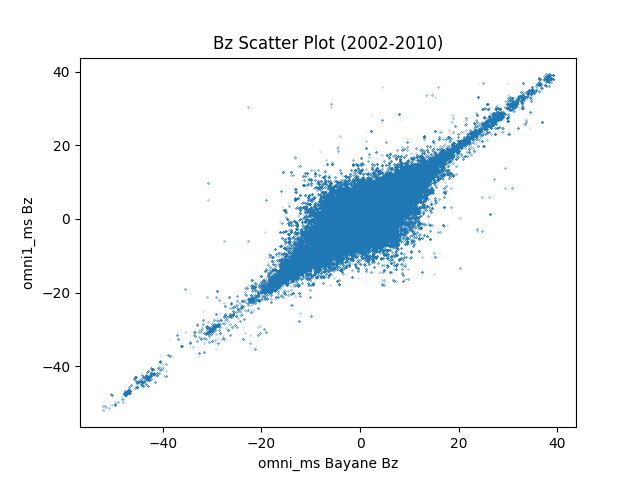

In [67]:
# Plot omni_ms; omni1_ms; omni2_ms
# omni_ms -> dataset from Bayane
# omni1_ms -> OMNI1 database downloaded from speazy
# omni2_ms -> OMNI2 database downloaded from speazy

start = '2002-01-01'
end = '2010-12-31'

mask1 = (omni_ms['time'] >= start) & (omni_ms['time'] <= end)
mask2 = (omni1_ms['time'] >= start) & (omni1_ms['time'] <= end)

x = omni_ms.loc[mask1, 'Bz']
y = omni1_ms.loc[mask2, 'Bz']

plt.close('all')   
plt.figure()
plt.scatter(x,y, marker='.', alpha=0.5, s=0.1)
plt.xlabel('omni_ms Bayane Bz')
plt.ylabel('omni1_ms Bz')
plt.title('Bz Scatter Plot (2002-2010)')
plt.show()



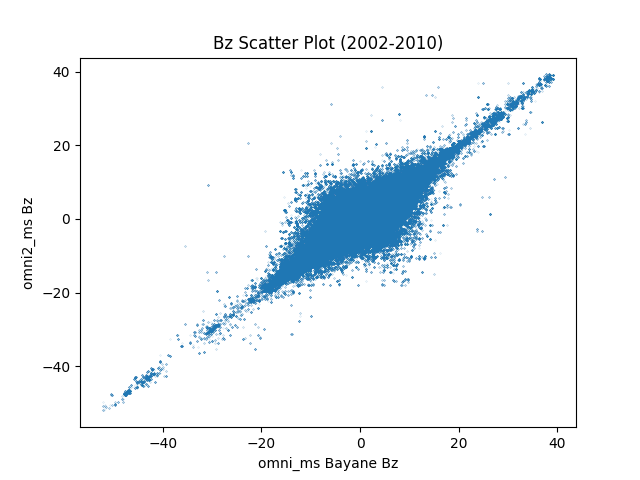

In [68]:
# Plot omni_ms; omni1_ms; omni2_ms
start = '2002-01-01'
end = '2010-12-31'

mask1 = (omni_ms['time'] >= start) & (omni_ms['time'] <= end)
mask2 = (omni2_ms['time'] >= start) & (omni2_ms['time'] <= end)

x = omni_ms.loc[mask1, 'Bz']
y = omni2_ms.loc[mask2, 'Bz']

   
plt.figure()
plt.scatter(x,y, marker='.', alpha=0.5, s=0.1)
plt.xlabel('omni_ms Bayane Bz')
plt.ylabel('omni2_ms Bz')
plt.title('Bz Scatter Plot (2002-2010)')
plt.show()


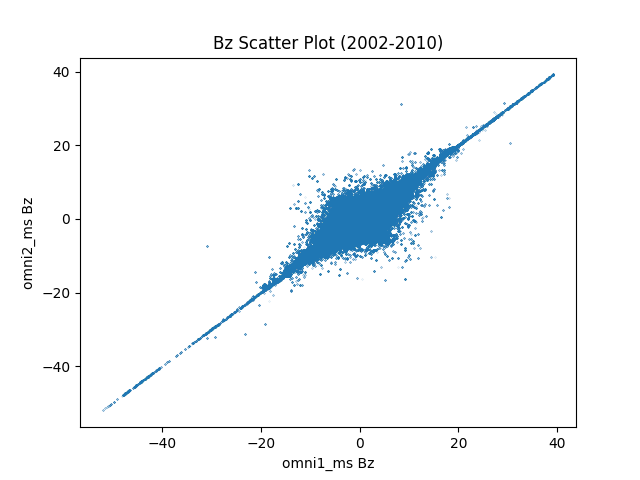

In [69]:
# Plot omni_ms; omni1_ms; omni2_ms
start = '2002-01-01'
end = '2010-12-31'

mask1 = (omni1_ms['time'] >= start) & (omni1_ms['time'] <= end)
mask2 = (omni2_ms['time'] >= start) & (omni2_ms['time'] <= end)

x = omni1_ms.loc[mask1, 'Bz']
y = omni2_ms.loc[mask2, 'Bz']

   
plt.figure()
plt.scatter(x,y, marker='.', alpha=0.5, s=0.1)
plt.xlabel('omni1_ms Bz')
plt.ylabel('omni2_ms Bz')
plt.title('Bz Scatter Plot (2002-2010)')
plt.show()

From the above plots, we can conclude the different datasets of OMNI can have some variance. Though the variance between OMNI1 and OMNI2 downloaded from speazy appears to be the least. 

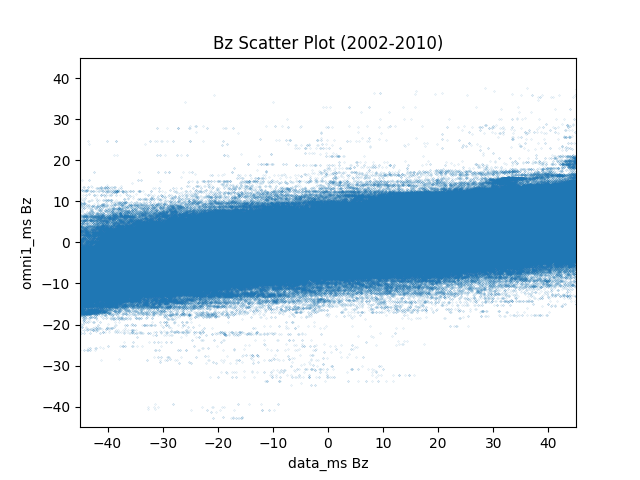

In [70]:
# Observing how the Bz values vary between the measurements within the meagnetosheath and the OMNI1

start = '2002-01-01'
end = '2010-12-31'

mask1 = (data_ms['time'] >= start) & (data_ms['time'] <= end )
mask2 = (omni1_ms['time'] >= start) & (omni1_ms['time'] <= end )
cond =  abs(pos_ms.Z<=1) & abs(pos_ms.Y<=1) & r_norm_ms<=0.2 

x = data_ms.loc[mask1, 'Bz']
y = omni1_ms.loc[mask2, 'Bz']

   
plt.figure()
plt.scatter(x[cond],y[cond], marker='.', alpha=0.5, s=0.1)
plt.xlabel('data_ms Bz')
plt.ylabel('omni1_ms Bz')
plt.title('Bz Scatter Plot (2002-2010)')
plt.xlim(-45, 45)
plt.ylim(-45, 45)
plt.show()



C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\4167357239.py:26: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=30, cmap='viridis', norm=LogNorm())


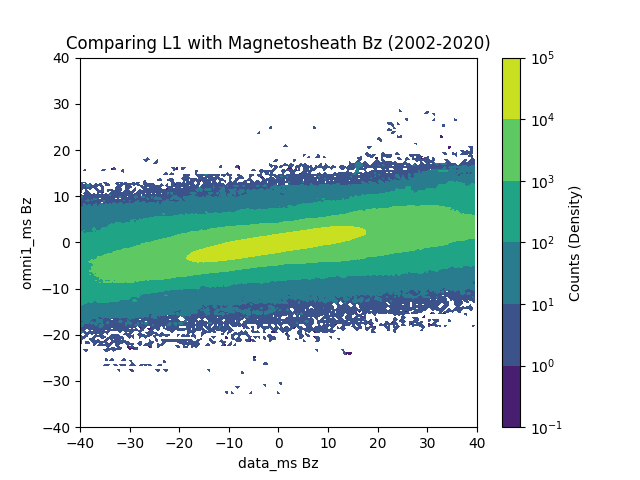

In [71]:
# Plotting the same as above, but as contour color plots to understand the density of data
start = '2002-01-01'
end = '2020-12-31'

mask1 = (data_ms['time'] >= start) & (data_ms['time'] <= end )
mask2 = (omni1_ms['time'] >= start) & (omni1_ms['time'] <= end )
cond =  abs(pos_ms.Z<=1) & abs(pos_ms.Y<=1) & r_norm_ms<=0.1 

x = data_ms.loc[mask1, 'Bz']
y = omni1_ms.loc[mask2, 'Bz']

xvals = x[cond].values
yvals = y[cond].values

# Define bins for the 2D histogram
xbins = np.linspace(-40, +40, 200)
ybins = np.linspace(-40, +40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=30, cmap='viridis', norm=LogNorm())
plt.xlabel('data_ms Bz')
plt.ylabel('omni1_ms Bz')
plt.title('Comparing L1 with Magnetosheath Bz (2002-2020)')
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()

C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\3002939479.py:27: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=50, cmap='viridis', norm=LogNorm())


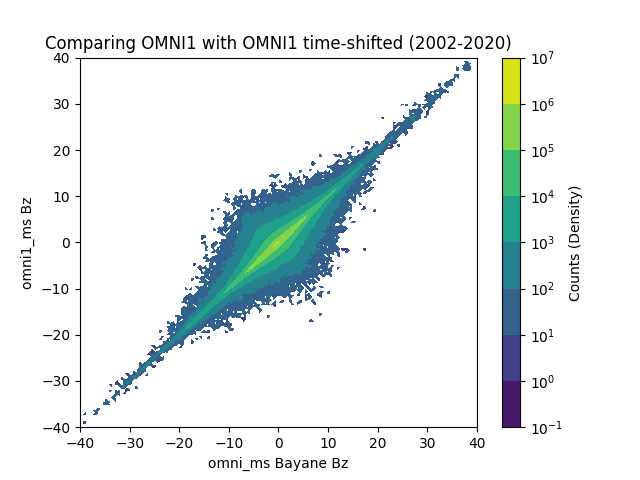

In [72]:
# Prepare data (using x[cond], y[cond])
start = '2002-01-01'
end = '2020-12-31'

mask1 = (omni_ms['time'] >= start) & (omni_ms['time'] <= end )
mask2 = (omni1_ms['time'] >= start) & (omni1_ms['time'] <= end )
#cond =  abs(pos_ms.Z<=1) & abs(pos_ms.Y<=1) & r_norm_ms<=0.2 

x = omni_ms.loc[mask1, 'Bz']
y = omni1_ms.loc[mask2, 'Bz']


xvals = x.values
yvals = y.values

# Define bins for the 2D histogram
xbins = np.linspace(-40, +40, 200)
ybins = np.linspace(-40, +40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=50, cmap='viridis', norm=LogNorm())
plt.xlabel('omni_ms Bayane Bz')
plt.ylabel('omni1_ms Bz')
plt.title('Comparing OMNI1 with OMNI1 time-shifted (2002-2020)')
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()

OMNI database from Bayane, is time-shifted in a particular way to match with the measurements made in the magnetosheath. OMNI1 is time shifted to the bow-shock nose. The difference in time shift does produce an error/variance as well.

C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\1074149971.py:26: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=30, cmap='viridis', norm=LogNorm())


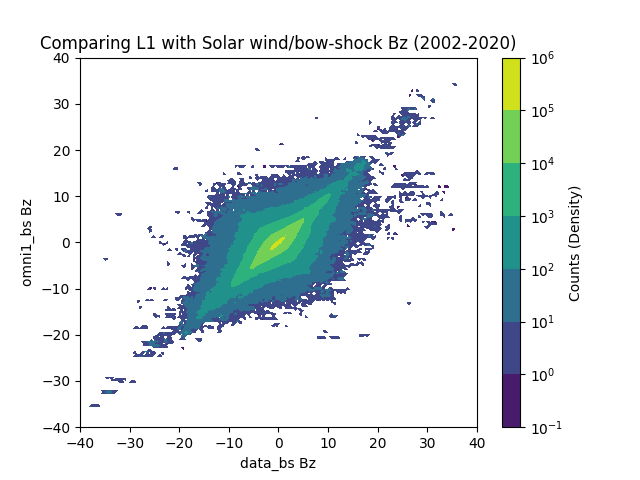

In [73]:
# Comparing measurements from the upstream of bowshock with that of OMNI1
start = '2002-01-01'
end = '2020-12-31'

mask1 = (data_bs['time'] >= start) & (data_bs['time'] <= end )
mask2 = (omni1_bs['time'] >= start) & (omni1_bs['time'] <= end )
cond =  abs(pos_ms.Z<=1) & abs(pos_ms.Y<=1) & r_norm_ms<=0.1 

x = data_bs.loc[mask1, 'Bz']
y = omni1_bs.loc[mask2, 'Bz']

xvals = x[cond].values
yvals = y[cond].values

# Define bins for the 2D histogram
xbins = np.linspace(-40, +40, 200)
ybins = np.linspace(-40, +40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=30, cmap='viridis', norm=LogNorm())
plt.xlabel('data_bs Bz')
plt.ylabel('omni1_bs Bz')
plt.title('Comparing L1 with Solar wind/bow-shock Bz (2002-2020)')
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()

In [74]:
# Function that produces 2D binned plots, to see a 2D/3D distribution of measurements in the magnetosphere
def hist_2d(x, y, qty_x, qty_y, qty_z, **kwargs):
    statistic = kwargs.get('statistic','mean')
    value = stats.binned_statistic_2d(qty_x, qty_y, qty_z, statistic=statistic, bins=[x,y]).statistic
    if kwargs.get('gaussian',False) :
        value =filter_nan_gaussian_conserving2(value, sigma=kwargs.get('sigma',(1,1)))
    return value

In [75]:
def EKL(vx, vy, vz, by, bz):
    """
    Returns Kan-Lee electric field in mV/m given solar wind V and B.

    Parameters
    ----------
    vx : float, array-like
        Solar wind GSE X velocity in km/s
    vy : float, array-like
        Solar wind GSE Y velocity in km/s
    vz : float, array-like
        Solar wind GSE Z velocity in km/s
    by : float, array-like
        Interplanetary magnetic field GSM Y component in nT
    bz : float, array-like
        Interplanetary magnetic field GSM Z component in nT

    Returns
    -------
    ekl : float, array-like
        Kan-Lee electric field in mV/m
    """

    # Calculate the Kan-Lee electric field
    ekl = 0.001 * np.sqrt(vx**2 + vy**2 + vz**2) * np.sqrt(by**2 + bz**2) * (np.sin(np.arctan2(by, bz) / 2)**2)

    return ekl

In [76]:
# Calculating the merging electric field, and the equivalent of it within the magnetosheath

omni2_ms['Ekl'] = EKL(omni2_ms.Vx, omni2_ms.Vy, omni2_ms.Vz, omni2_ms.By, omni2_ms.Bz) # Kan Lee Electric field calculated from L1 data for corresponding ms data
omni1_ms['Ekl'] = EKL(omni1_ms.Vx, omni1_ms.Vy, omni1_ms.Vz, omni1_ms.By, omni1_ms.Bz) # Kan Lee Electric field calculated from L1 data for corresponding ms data
omni_ms['Ekl'] = EKL(omni_ms.Vx, omni_ms.Vy, omni_ms.Vz, omni_ms.By, omni_ms.Bz) # Kan Lee Electric field calculated from L1 data for corresponding ms data
data_ms['Ekl'] = EKL(data_ms.Vx, data_ms.Vy, data_ms.Vz, data_ms.By, data_ms.Bz) # Kan Lee Electric field calculated at magnetosheath

omni2_bs['Ekl'] = EKL(omni2_bs.Vx, omni2_bs.Vy, omni2_bs.Vz, omni2_bs.By, omni2_bs.Bz) # Kan Lee Electric field calculated from L1 data for corresponding ms data
omni1_bs['Ekl'] = EKL(omni1_bs.Vx, omni1_bs.Vy, omni1_bs.Vz, omni1_bs.By, omni1_bs.Bz) # Kan Lee Electric field calculated from L1 data for corresponding ms data

data_bs['Ekl'] = EKL(data_bs.Vx, data_bs.Vy, data_bs.Vz, data_bs.By, data_bs.Bz) # Kan Lee Electric field calculated at magnetosheath

In [77]:
# Creating the grid for 2D-histogram plotting
x,y =np.linspace(0,15,50),np.linspace(-30,30,100) 
X,Y = np.meshgrid(x,y,indexing='ij')


In [78]:
# Creating a filter for data that will be used in binning 
# Along Y direction, 5RE span; Along Z direction, 5 RE span

# cond = (abs(pos.Z)<=1) & (omni2_ms.Bz<20) & (omni2_ms.Bz>=-20) & (r_norm<=0.5) & (abs(pos.Y)<=3) 
cond = (abs(pos_ms.Z)<=5) & (omni2_ms.Bz<20) & (omni2_ms.Bz>=-20) & (r_norm_ms<=0.5) & (abs(pos_ms.Y)<=5) 
#cond = (abs(pos_ms.Z)<=1) & (omni.Bz<20) & (omni.Bz>=-20)
#cond = (abs(pos_ms.Z)<=1) & (r_norm<=1)

print("samples =",np.sum(cond),", Percent of data =",np.sum(cond)/len(data_ms)*100)

# 2D-histogram values stored in variable
b = hist_2d(x,y, pos_ms[cond].X, pos_ms[cond].Y, data_ms[cond].Bz,statistic='std')

print("mean =",np.mean(data_ms[cond].Bz))

print("max std =",np.nanmax(b),", mean std =",np.nanmean(b))

samples = 6629948 , Percent of data = 14.766735971385003
mean = 2.57793113248301
max std = 43.60608704311217 , mean std = 22.397026427856524


Text(0.5, 0, ' X GSE [$R_E$]')

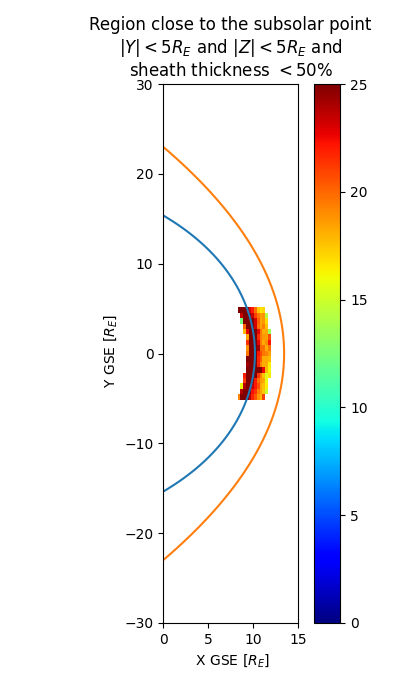

In [79]:
# Plotting magnetosheath boundaries
mp, bs = msh.boundaries(np.linspace(-np.pi/2,np.pi/2,100),np.pi/2)

fig,axs = plt.subplots(figsize=(4,7))
axs.plot(mp[0],mp[1])
axs.plot(bs[0],bs[1])
c = axs.pcolormesh(X,Y,b,cmap='jet')
fig.colorbar(c)
c.set_clim(0,25)
axs.set_aspect('equal')
axs.set_aspect('equal')
plt.title(r"Region close to the subsolar point"
            "\n" 
            r"$|Y|<5 R_E$ and $|Z|<5 R_E$ and"
            "\n"
            r"sheath thickness $< 50\%$")
plt.ylabel(r' Y GSE [$R_E$]')
plt.xlabel(r' X GSE [$R_E$]')

In [80]:
# Calculate the variance of the data for given L1 measurement and Magnetosheath data
# -5 RE < Y < 5 RE, -5 RE < Z < 5 RE, Rnorm < 0.5
bins = np.concatenate([np.arange(0, 2, 0.1), np.arange(2, 25, 1)])
#bins = np.arange(0,40,1)
mx = []
sx = []
mx2 = []
sx2 = []


for i in range(len(bins) - 1):
    print(i)
    #cond = (abs(pos.Z)<=1) & (abs(pos.Y)<=3) & (omni.Bz>=bin[i]) & (omni.Bz<bin[i+1]) & (r_norm_ms<=0.5)
    #cond2 = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.2) 
    cond2 = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.5) 
    #cond2 = (abs(pos_ms.Z)<=200) & (abs(pos_ms.Y)<=200) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=1) & (abs(data_ms.Bz)<=100) 
    #cond = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (omni2_ms.Ekl>=bins[i]) & (omni2_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.2)
    #print(np.mean(data_ms.Ekl[cond]))
    #print(np.sum(cond2))
    mx2.append(np.nanmean(omni2_ms.Ekl[cond2]))
    sx2.append(np.nanstd(omni2_ms.Ekl[cond2]))
    mx.append(np.nanmean(data_ms.Ekl[cond2]))
    sx.append(np.nanstd(data_ms.Ekl[cond2]-omni2_ms.Ekl[cond2]))
    #sx.append(np.nanstd(omni2_ms.Ekl[cond2]))
    #print(mx[i])
    #print(sx[i])
        
        
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [81]:
# Calculate the variance of the data for given L1 measurement and Solar wind data
bins = np.concatenate([np.arange(0, 2, 0.1), np.arange(2, 25, 1)])
#bins = np.arange(0,40,1)
mx_bs = []
sx_bs = []
mx2_bs = []
sx2_bs = []


for i in range(len(bins) - 1):
    print(i)
    #cond = (abs(pos.Z)<=1) & (abs(pos.Y)<=3) & (omni.Bz>=bin[i]) & (omni.Bz<bin[i+1]) & (r_norm_ms<=0.5)
    #cond2 = (abs(pos_bs.Z)<=5) & (abs(pos_bs.Y)<=5) & (data_bs.Ekl>=bins[i]) & (data_bs.Ekl<bins[i+1]) 
    cond2 = (abs(pos_bs.Z)<=200) & (abs(pos_bs.Y)<=200) & (data_bs.Ekl>=bins[i]) & (data_bs.Ekl<bins[i+1]) 
    #cond = (abs(pos_bs.Z)<=5) & (abs(pos_bs.Y)<=5) & (omni2_bs.Ekl>=bins[i]) & (omni2_bs.Ekl<bins[i+1]) 
    #print(np.mean(data_bs.Ekl[cond]))
    #print(np.size(data_bs.Ekl[cond]))
    #print(np.sum(cond2))
    mx2_bs.append(np.nanmean(omni2_bs.Ekl[cond2]))
    sx2_bs.append(np.nanstd(omni2_bs.Ekl[cond2]))
    mx_bs.append(np.nanmean(data_bs.Ekl[cond2]))
    sx_bs.append(np.nanstd(data_bs.Ekl[cond2]-omni2_bs.Ekl[cond2]))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


### Plotting the uncertainty in solar wind kan-lee electric field for given reconnection electric field in the magnetosheath 
Kan-Lee electric field is defined as $E_{m} = V_{sw} B_{T, sw} sin^2(\theta_{cl}/2)$ (See [Kan and Lee 1979](https://doi.org/10.1029/GL006i007p00577)). But Kan and Lee derives this formula from an estimate of the projection of the reconnection electric field onto the dawn-dusk direction in the polar cap, which is equal to $E^{sh}_{m} = V_{sh} B_{sh} sin^2(\theta'/2)$ where $\theta'$ is the angle between the magnetic field in the sheath and the magnetospheric magnetic field across the magnetopause boundary. This $E_m$ is what kan and lee believes should be equal to the cross-polar cap /dawn-dusk electric field. 

By making two main assumptions:

$\theta' = \theta_{cl}$

and 

$V_{sw} B_{T,sw} = V_{sh} B_{sh}$, which is likely the case for a solar wind with $V_{sw, T} = 0$ and $B_{n,sw} = 0$. This is likely true on average for the solar wind. However, this would lead to a random difference between $E^{sh}_{m}$ and $E_{m}^{bs}$ (just upstream of the bowshock in the solar wind), though their values are same on average! In fact, though the bow shock reduces the velocity of the plasma, it increases the magnetic field such that for a solar wind with relatively low tangential velocity, the product of $V B_T$ is the same across the shock. 

Hence we plot below the variance of the L1 estimate of the kan-lee electric field for a given value of $E^{sh}_{m}$, as well as given value of $E_{kl}^{bs}$ just upstream of the shock. 

Note: Samples of data are poor for values of $E_{m}^{sh}$ > 12 mV/m, while more samples available for $E_{m}^{bs}$ > 12 mV/m". Hence the effective error that we use in our paper is the maximum value of either $E_{m}^{sh}$ or $E_{m}^{bs}$. In fact, this would be a conservative estimate. 

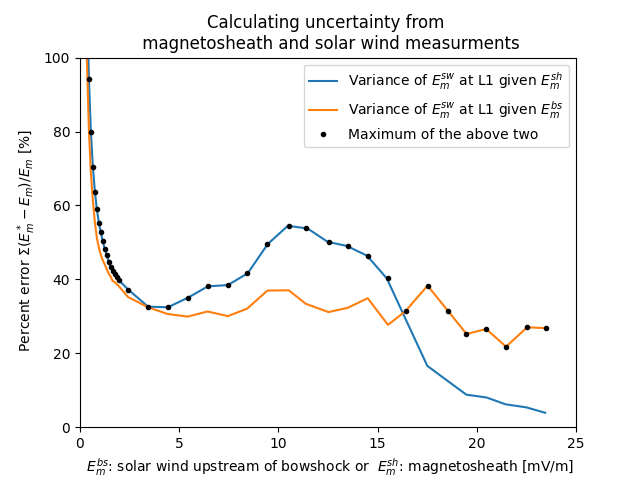

In [82]:
plt.figure()
#plt.plot(bins[0:-1],sx)
y1 = np.divide(sx_bs,mx_bs)*100
y2 = np.divide(sx,mx)*100

plt.plot(mx,np.divide(sx,mx)*100)
plt.plot(mx_bs,np.divide(sx_bs,mx_bs)*100)
plt.plot(mx_bs,np.maximum(y1, y2),'k.')
plt.ylim(0,100)
plt.xlim(0,25)
plt.ylabel(r' Percent error $\Sigma (E_{m}^* - E_{m})/E_{m}$ [%]')
plt.xlabel(r' $E_{m}^{bs}$: solar wind upstream of bowshock or  $E_{m}^{sh}$: magnetosheath [mV/m]')
plt.legend([r'Variance of $E_{m}^{sw}$ at L1 given $E_{m}^{sh}$',r'Variance of $E_{m}^{sw}$ at L1 given $E_{m}^{bs}$','Maximum of the above two'])
plt.title('Calculating uncertainty from \n magnetosheath and solar wind measurments')

#plt.plot(bins[0:-1],bins[0:-1])

plt.show()

Uncertainty in $E^{sw-L1}_{m}$ for a given $E^{sh}_{m}$ is reliable only up to 12-15mV/m because of poor statistics beyond 12 mV/m (See In [24]), hence, its safe to assume the uncertainty for values >15 mV/m is at least as much as the variance in $E^{sw-L1}_{m}$ for a given $E^{bs-bowshock}_{m}$ value. 

In [83]:
# Saving the above error estimates to a matlab file to be used in Code 1
import scipy.io

# Store variables into a .mat file
scipy.io.savemat('bayanne_uncertainty_stats.mat', {
    'std_ekl_ms': sx,
    'mean_ekl_ms': mx,
    'std_ekl_bs': sx_bs,
    'mean_ekl_bs': mx_bs,
    'bins': bins,
    'description_ms': 'std_ekl_ms: np.nanstd(data_ms.Ekl[cond2]-omni2_ms.Ekl[cond2]); mx_ekl_ms: np.nanmean(data_ms.Ekl[cond2]); cond2 = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.5)',
    'description_bs': 'std_ekl_bs: np.nanstd(data_bs.Ekl[cond2]-omni2_bs.Ekl[cond2]); mx_ekl_bs: np.nanmean(data_bs.Ekl[cond2]); cond2 = (abs(pos_bs.Z)<=200) & (abs(pos_bs.Y)<=200) & (data_bs.Ekl>=bins[i]) & (data_bs.Ekl<bins[i+1])',
    'corresponding_python_code': 'Nithin_MSH_v3.ipynb'
})

C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\199766739.py:20: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())


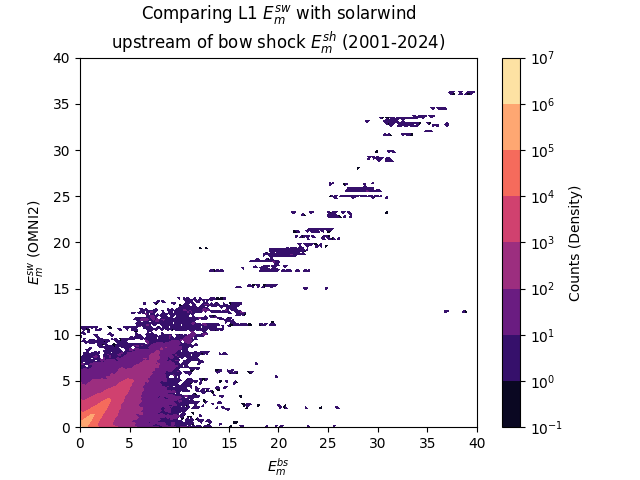

In [84]:
# Compare Ekl

#cond =  abs(pos_ms.Z<=1) & abs(pos_ms.Y<=1) & r_norm_ms<=0.1 

xvals = data_bs.Ekl
yvals = omni2_bs.Ekl


# Define bins for the 2D histogram
xbins = np.linspace(0, 40, 200)
ybins = np.linspace(0, 40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())
plt.xlabel(r'$E_{m}^{bs}$')
plt.ylabel(r'$E_{m}^{sw}$ (OMNI2)')
plt.title('Comparing L1 with Solar wind/bow-shock Ekl (2001-2024)')
plt.title(r"Comparing L1 $E_{m}^{sw}$ with solarwind"
            "\n" 
            r"upstream of bow shock $E_{m}^{sh}$ (2001-2024)")
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()

4.7262006


C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\4261511416.py:23: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())


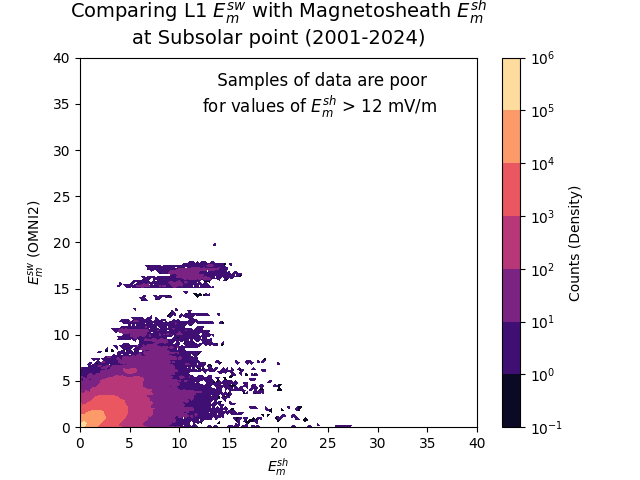

In [85]:
# Compare Ekl
cond =  (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (r_norm_ms<=0.5)  & (abs(data_ms.Bz)<=100) 
#cond =  (abs(pos_ms.Z)<=500) & (abs(pos_ms.Y)<=500) & (r_norm_ms<=1)
#cond = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.2)

xvals = data_ms.Ekl[cond]
yvals = omni2_ms.Ekl[cond]


print(np.nanstd(yvals[(xvals>=9) & (xvals<=10)]))

# Define bins for the 2D histogram
xbins = np.linspace(0, +40, 200)
ybins = np.linspace(0, +40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())
plt.xlabel(r'$E_{m}^{sh}$')
plt.ylabel(r'$E_{m}^{sw}$ (OMNI2)')
plt.title(r"Comparing L1 $E_{m}^{sw}$ with Magnetosheath $E_{m}^{sh}$"
            "\n" 
            "at Subsolar point (2001-2024)", fontsize=14, loc='center', pad=10)
plt.suptitle("\n \n \n Samples of data are poor" 
                "\n"
                r"for values of $E_{m}^{sh}$ > 12 mV/m")
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()

We note in the above plot that for magnetosheath values of $E^{sh}_m$ greater than 12-15 mV/m there is not enough data to get a reliable estimate of the variance of L1 measurements of the same. 

2.0421128


C:\Users\nithin\AppData\Local\Temp\ipykernel_75484\4214866635.py:23: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())


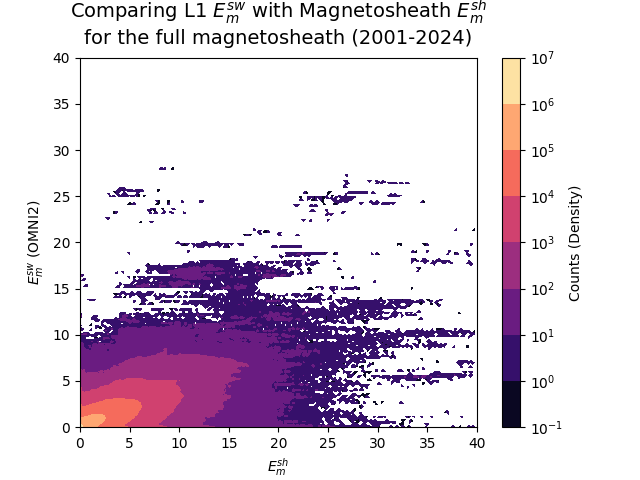

In [86]:
# Compare Ekl
cond =  (abs(pos_ms.Z)<=500) & (abs(pos_ms.Y)<=500) & (r_norm_ms<=1)
#cond =  (abs(pos_ms.Z)<=500) & (abs(pos_ms.Y)<=500) & (r_norm_ms<=1)
#cond = (abs(pos_ms.Z)<=5) & (abs(pos_ms.Y)<=5) & (data_ms.Ekl>=bins[i]) & (data_ms.Ekl<bins[i+1]) & (r_norm_ms<=0.2)

xvals = data_ms.Ekl[cond]
yvals = omni2_ms.Ekl[cond]


print(np.nanstd(yvals[(xvals>=9) & (xvals<=10)]))

# Define bins for the 2D histogram
xbins = np.linspace(0, +40, 200)
ybins = np.linspace(0, +40, 200)

# Compute 2D histogram (density/frequency)
H, xedges, yedges = np.histogram2d(xvals, yvals, bins=[xbins, ybins])

# Create meshgrid for plotting
X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

plt.figure()
contour = plt.contourf(X, Y, H, levels=30, cmap='magma', norm=LogNorm())
plt.xlabel(r'$E_{m}^{sh}$')
plt.ylabel(r'$E_{m}^{sw}$ (OMNI2)')
plt.title(r"Comparing L1 $E_{m}^{sw}$ with Magnetosheath $E_{m}^{sh}$"
            "\n" 
            "for the full magnetosheath (2001-2024)", fontsize=14, loc='center', pad=10)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.colorbar(contour, label='Counts (Density)')
plt.show()



In the above plot we note that if we expand the sample of the magnetosheath data beyond the subsolar point, more statistics are available, however, we will deviate from the meaning of the reconnection electric field when we go outside the subsolar point/region defined by the plot in Cell 18.

### Saving certain data to run reduced code for peer-review

In [87]:
# Save selected variables to a pickle file for downstream use
import pickle
import gzip
# Collect variables to save. If any variable is a pandas Series or DataFrame, we convert to values or keep as-is so they pickle cleanly.
data_to_save = {
    'omni2_ms_Ekl': omni2_ms['Ekl'] if 'Ekl' in omni2_ms.columns else omni2_ms.Ekl,
    'data_ms_Ekl': data_ms['Ekl'] if 'Ekl' in data_ms.columns else data_ms.Ekl,
    'data_bs_Ekl' : data_bs['Ekl'] if 'Ekl' in data_bs.columns else data_bs.Ekl,
    'pos_ms_Z'    : pos_ms['Z'] if 'Z' in pos_ms.columns else pos_ms.Z,
    'pos_ms_Y'    : pos_ms['Y'] if 'Y' in pos_ms.columns else pos_ms.Y,
    'r_norm_ms'   : r_norm_ms,
    'pos_bs_Z'    : pos_bs['Z'] if 'Z' in pos_bs.columns else pos_bs.Z,
    'pos_bs_Y'    : pos_bs['Y'] if 'Y' in pos_bs.columns else pos_bs.Y,
}
# Write to pickle file in the notebook workspace folder
outfile = 'ekl_and_positions.pkl'
with gzip.open(outfile, 'wb', compresslevel=9) as f:
    pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f'Saved variables to {outfile}')

Saved variables to ekl_and_positions.pkl


In [88]:
# Save selected variables to a pickle file for downstream use
import pickle
import gzip
# Collect variables to save. If any variable is a pandas Series or DataFrame, we convert to values or keep as-is so they pickle cleanly.
data_to_save = {
    'omni2_bs_Ekl': omni2_bs['Ekl'] if 'Ekl' in omni2_bs.columns else omni2_bs.Ekl,
    'data_ms_Bz': data_ms['Bz'] if 'Bz' in data_ms.columns else data_ms.Bz,
}
# Write to pickle file in the notebook workspace folder
outfile = 'bs_ekl_and_ms_Bz.pkl'
with gzip.open(outfile, 'wb', compresslevel=9) as f:
    pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f'Saved variables to {outfile}')

Saved variables to bs_ekl_and_ms_Bz.pkl
